In [260]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score
from math import pi
from helpers.other_helpers import *
from helpers.viz_helpers import *
pd.set_option('display.float_format', '{:.2f}'.format)


# Extraction des données depuis S3

Dans ce notebook, nous allons extraire les données prétraitées sur lesquelles nous avons travaillé dans le notebook intermédiaire **`1.extraction_donnees.ipynb`**. Ces données, désormais prêtes pour l'utilisation et l'analyse, sont stockées dans un service de stockage **S3**.




In [278]:
s3 = s3_connection()
df = s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
df.sample(3)

connection successful


,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km,regions
986,408987,Ponthierry - Pringy,87682526,77407,2.54,48.53,77407,ST-FARGEAU-PONTHIERRY,16168.00,19153.64,...,0.38,0.00,0.08,0.16,0.33,0.27,0.15,0.07,2.18,Île-de-France
957,11034,Nonancourt,87393553,27438,1.19,48.78,27438,NONANCOURT,2225.00,14089.54,...,0.13,0.00,0.00,0.09,0.16,0.61,0.14,0.12,13.90,Normandie
2389,228,Estavar,87784827,66072,2.02,42.46,66072,ESTAVAR,552.00,14175.49,...,0.43,0.04,0.03,0.28,0.15,0.31,0.19,0.08,1.36,Occitanie


# Analyse préliminaire : Vérification des Outliers et des Échelles des Données

Avant de procéder à l'analyse approfondie, il est essentiel de vérifier si les données contiennent des **outliers** ou si les **échelles des variables** sont différentes. Cette étape est cruciale pour plusieurs raisons :

- **Visualisations adaptées** : Les visualisations doivent prendre en compte les non-linéarités des tendances et la présence éventuelle d'outliers.
- **Algorithmes de machine learning** : Certains algorithmes nécessitent la standardisation des variables pour fonctionner correctement, notamment lorsque les échelles des variables diffèrent.

## Objectif
Pour détecter la présence d'outliers et évaluer les échelles des variables, nous allons examiner les **quantiles** des différentes variables du jeu de données.




In [279]:
df.describe().drop("count").drop(columns=["lon_gare", "lat_gare"]).round(2)

,total_voyageurs_2022,pop2022,revmoy2022,pbac2022,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km
mean,745465.89,18078.54,18221.52,0.46,0.29,0.01,0.07,0.14,0.26,0.29,0.23,0.07,4.86
std,3178484.88,50290.90,6608.60,0.13,0.13,0.04,0.06,0.11,0.11,0.11,0.12,0.05,3.73
min,1.00,55.00,5818.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
25%,12938.50,1570.25,14922.08,0.37,0.20,0.00,0.04,0.07,0.21,0.23,0.14,0.04,2.22
50%,60333.50,4067.50,16931.46,0.45,0.28,0.00,0.06,0.12,0.26,0.29,0.22,0.07,3.82
75%,289815.25,12203.00,19639.30,0.54,0.37,0.01,0.09,0.19,0.31,0.35,0.30,0.10,6.27
max,102910589.00,875791.00,107572.81,1.00,1.00,0.58,0.67,0.82,0.92,1.00,1.00,0.48,30.39




### 1. Observation des Outliers
- Pour la variable **`total_voyageurs_2022`** :
  - La **std (écart-type)** est très élevée par rapport à la moyenne.
  - Le **maximum** est environ **300 fois plus élevé** que le 75e percentile, indiquant la présence d'outliers extrêmement importants.

- Pour la variable **`population`** :
  - Des outliers sont également détectés, bien que moins sévères que pour `total_voyageurs_2022`.

### 2. Échelles des Variables
- Les échelles des variables diffèrent entre :
  - Les **variables de comptage** (par exemple, `total_voyageurs_2022`, `population`) 
  - Les **pourcentages**.
- Cette différence d'échelle sera prise en compte lors des étapes ultérieures de standardisation et d'analyse.

### 3. Valeurs Nulles ou Zéros dans les Données Agricoles
- Pour les données d’agriculture, un grand nombre de **0** est observé :
  - Ces **0** pourraient représenter des valeurs réelles (absence d'activité agricole).
  - Ils pourraient également indiquer des données manquantes.
- Malheureusement, nous ne pouvons pas confirmer cela, car ces données proviennent du format original sans métadonnées explicites.

---
## Log-linéarisation des Variables

Étant donné la présence d'outliers et les tendances non linéaires dans certaines variables, nous allons **appliquer une transformation logarithmique** sur ces dernières. Cette étape est utile pour :

- **Réduire l'effet des outliers** en compressant les valeurs extrêmes.
- **Mieux représenter les tendances** dans les visualisations.
- **Améliorer la performance** de certains algorithmes sensibles aux échelles et à la distribution des données.

### Approche
Pour déterminer les variables nécessitant une transformation logarithmique, nous avons effectué plusieurs tests "trial and error" :
- Comparaison des graphiques avec et sans transformation logarithmique.
- Évaluation des distributions des variables.

### Liste des Variables à Log-linéariser
Voici les variables identifiées comme nécessitant une transformation logarithmique :



In [280]:
df["total_voyageurs_2022_log"] =  np.log(df["total_voyageurs_2022"])
df["pop2022_log"] =  np.log(df["pop2022"])
df["pagri2022_log"] =  np.log(df["pagri2022"]+0.0001)
df["ratio_voyag_popul"] =  df["total_voyageurs_2022"] / df["pop2022"]
df["ratio_voyag_popul_log"] =  np.log(df["total_voyageurs_2022"] / df["pop2022"])
df["dist_closest_station_km_log"] =  np.log(df["dist_closest_station_km"])
df_no_outliers = delete_outliers_z_score(df, (df["total_voyageurs_2022_log"]))



nb removed observations :  18


## Identification et Suppression des Outliers : Méthode Z-Score


Pour rendre notre analyse plus crédible, nous utilisons la méthode du **Z-score** pour identifier et éliminer les outliers de la variable (`total_voyageurs`). Cette méthode part du principe que les données suivent une distribution normale, ce qui justifie l'application de la transformation logarithmique, comme illustré dans le graphique ci-dessous.

### Résultats de l'Élimination des Outliers
- **18 gares** ont été supprimées de l'analyse, sur un total de **environ 2 500 gares**, soit un ratio raisonnable pour ce type de traitement.
- Parmi ces 18 gares :
  - La **Gare du Nord à Paris**, avec un nombre maximal de voyageurs, est un exemple d'outlier important.
  - Les **petites gares**, comptant entre **1 et 10 voyageurs**, ont également été exclues.
  
  Cette suppression est justifiée, car pour explorer les **tendances générales en France**, ces cas extrêmes ne sont pas représentatifs et pourraient biaiser l'analyse.

### Impact des Outliers
Pour démontrer à quel point les outliers influencent les résultats, nous comparons les histogrammes des données :
1. **Sans transformation logarithmique.**
2. **Avec transformation logarithmique.**
3. **Après élimination des outliers.**

Ces analyses sont effectuées pour deux variables clés :
- Le **nombre de voyageurs** (`total_voyageurs`).
- Le **ratio voyageurs/population** de la commune.



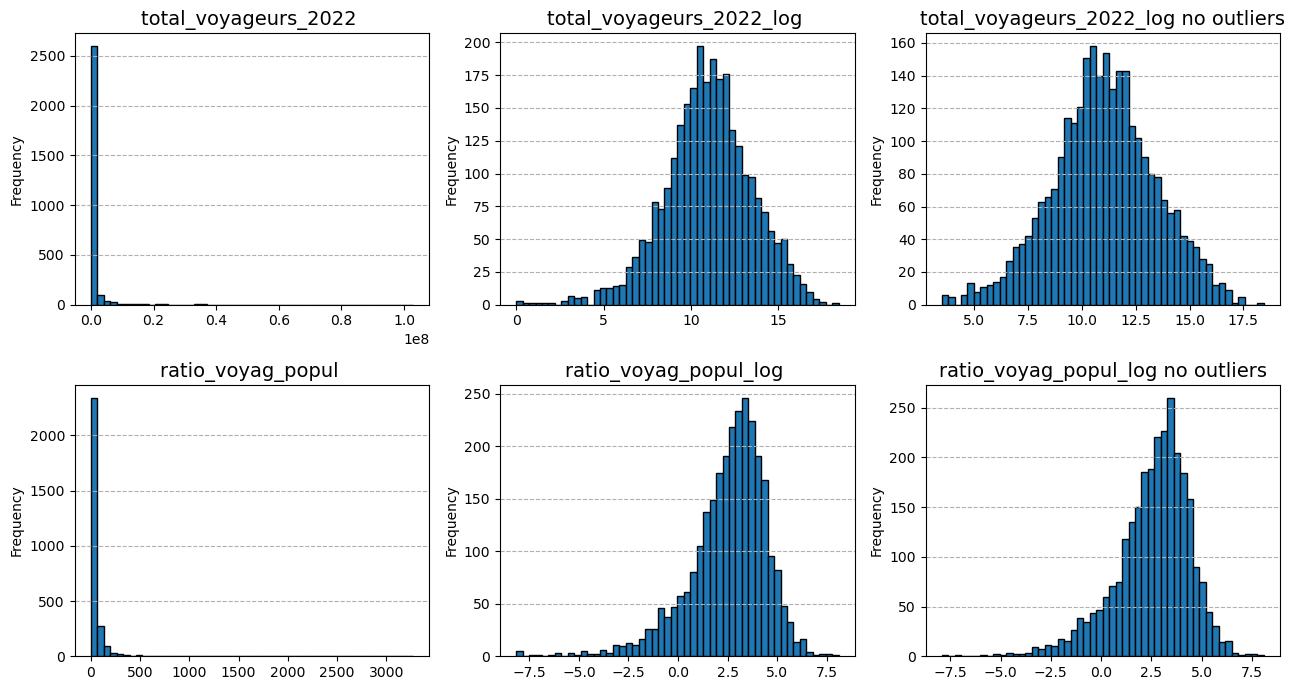

In [ ]:
#j'appelle la fonction centrale de tout ce projet qui regroupe plusieurs types de graphques en utilisant une commande très simple et intuitive
plot_square(fields_names=[
    [df["total_voyageurs_2022"]],
    [df["total_voyageurs_2022_log"]],
    [df_no_outliers["total_voyageurs_2022_log"],"no outliers"],
    [df["ratio_voyag_popul"]],
    [df["ratio_voyag_popul_log"]],
    [df_no_outliers["ratio_voyag_popul_log"],"no outliers"],
    ],
    plot_type="hist",
    columns=3)


---
## Visualisation : Carte des Stations en France


Pour mieux comprendre la répartition des gares en France, nous utilisons les données de **latitude** et **longitude** (lat/lon) disponibles dans le jeu de données original. Bien que les polygones géographiques ne soient pas fournis, ces coordonnées suffisent pour réaliser une **visualisation géographique**.

### Objectifs
1. **Étudier la charge des gares** : Identifier les zones à forte charge.
2. **Explorer les potentiels clusters géographiques** des gares : Examiner si la répartition est influencée par des facteurs géographiques tels que la région ou la commune.

### Étapes
1. Agréger les statistiques clés au **niveau régional** pour simplifier la visualisation et rendre les tendances plus claires.
   - Calculer des métriques telles que :
     - La somme des voyageurs par région.
     - Le revenu moyen  par région.
     - Le ratio voyageurs/population par région.
     ...
2. Visualiser les données agrégées sur une **carte de France**.

In [270]:
df=df_no_outliers.copy()
aggregated_stats = calculate(
    df,
    group=["regions"],
    fields_stats_names=[
        ["total_voyageurs_2022", "sum"],
        ["pop2022", "sum"],
        ["revmoy2022", "mean"],
        ["pbac2022", "mean"],
        ["pagri2022", "mean"],
        ["pindp2022", "mean"],
        ["pcadr2022", "mean"],
        ["pempl2022", "mean"],
        ["pouvr2022", "mean"],
        ["pchom2022", "mean"],
        
    ],
)
df_for_map = df.merge(aggregated_stats, on="regions", how="inner")

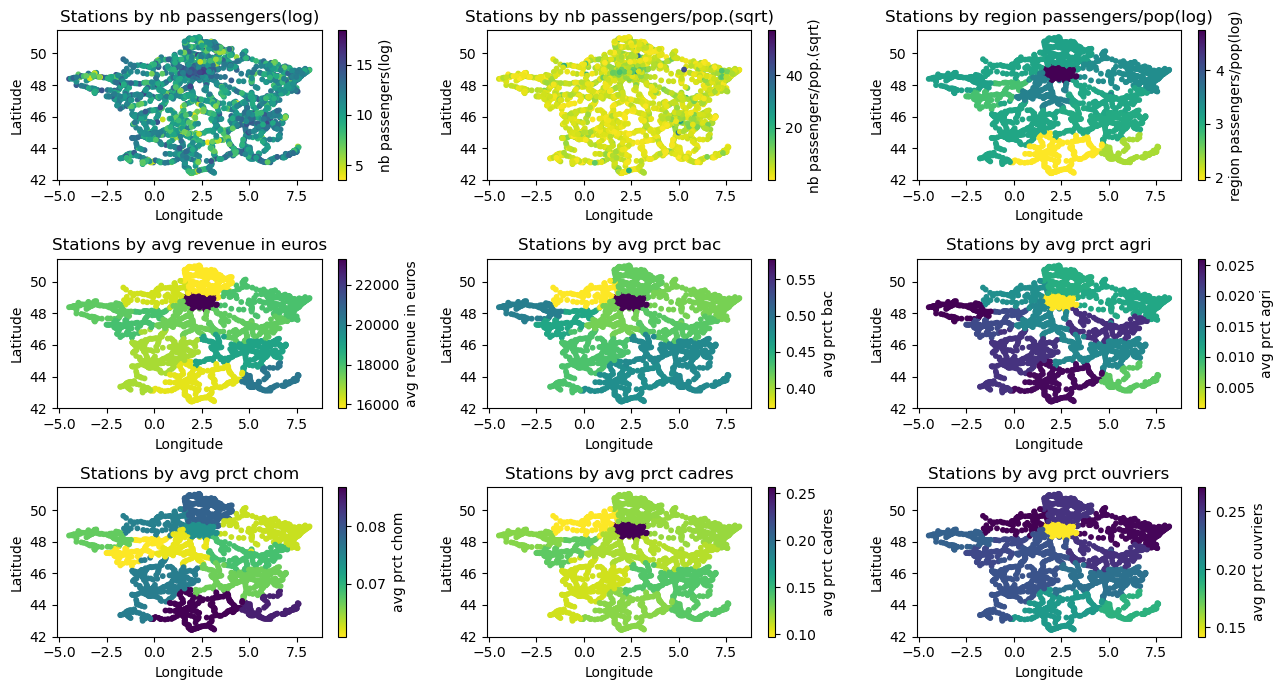

In [ ]:
#j'utilise encore une fois la fonction centrale pour cette fois si faire le plot des cartes de France, encore une fois avec une seule commande très simple
plot_square(lon=df_for_map["lon_gare"],lat=df_for_map["lat_gare"],
    fields_names=[
        [df_for_map["total_voyageurs_2022_log"], "nb passengers(log)"],

        [np.sqrt(df_for_map["ratio_voyag_popul"]),"nb passengers/pop.(sqrt)"],

        [np.log(df_for_map["total_voyageurs_2022_sum"]/ df_for_map["pop2022_sum"]),"region passengers/pop(log)"],

        [(df_for_map["revmoy2022_mean"]),"avg revenue in euros"],
        [df_for_map["pbac2022_mean"],"avg prct bac"],
        [df_for_map["pagri2022_mean"],"avg prct agri"],
        [df_for_map["pchom2022_mean"],"avg prct chom"],
        [df_for_map["pcadr2022_mean"],"avg prct cadres",],
        [df_for_map["pouvr2022_mean"],"avg prct ouvriers",]      
        ], 
        plot_type="map",
        columns=3,
)

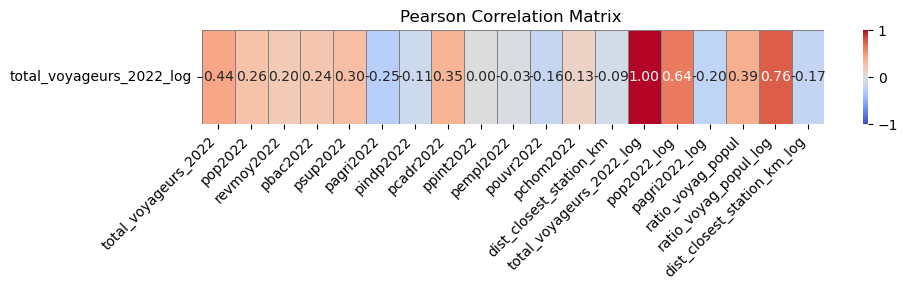

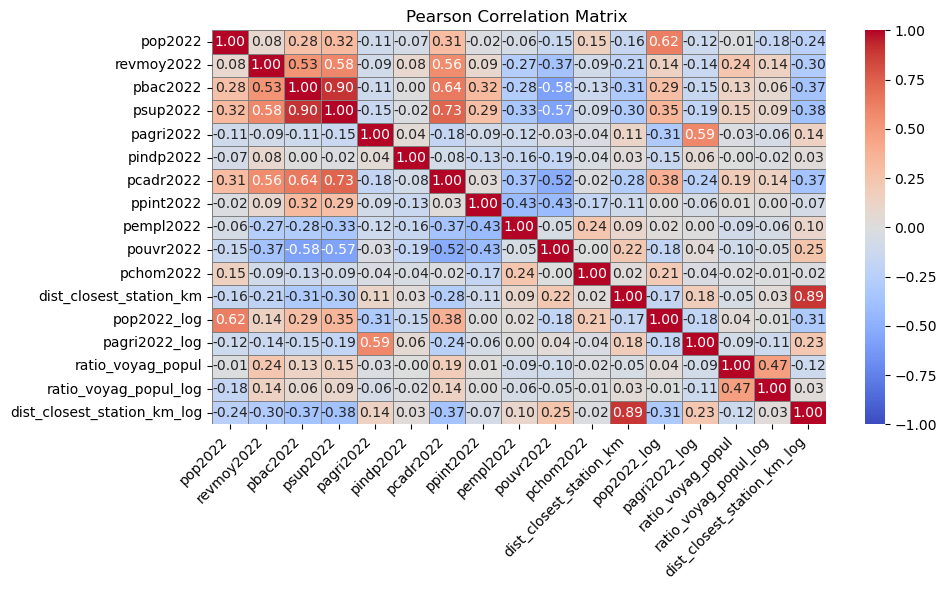

In [239]:
corr_matrix(df,filter_include=["total_voyageurs_2022_log"],filter_exclude=["lon_gare","lat_gare"],figsize=(10,3))
corr_matrix(df,filter_exclude=["total_voyageurs_2022_log","total_voyageurs_2022","lon_gare","lat_gare"])



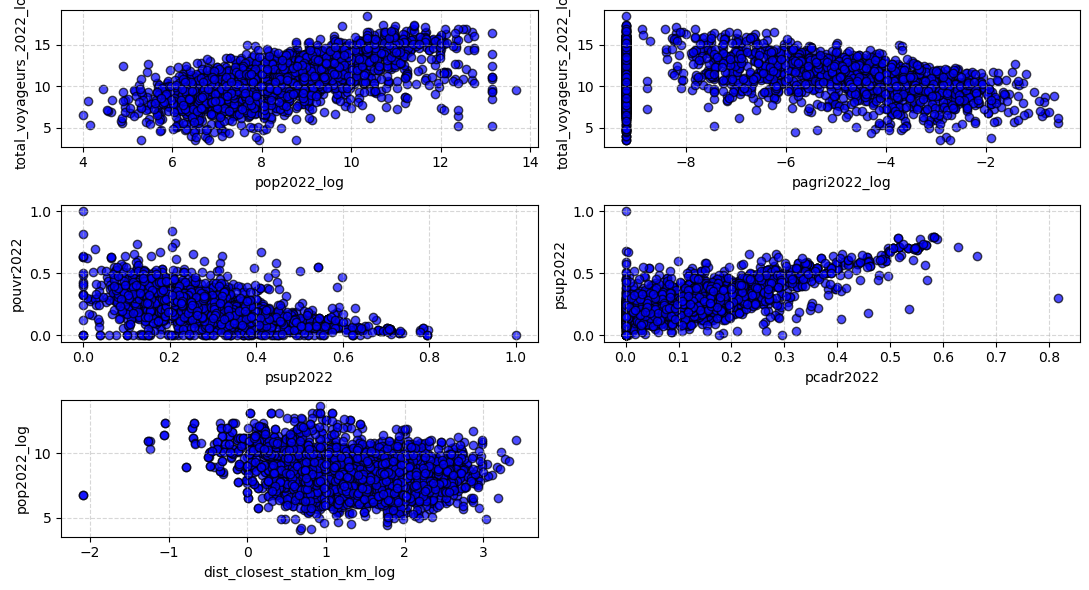

In [240]:
plot_square(fields_names=[
        [df['pop2022_log'], df['total_voyageurs_2022_log']] ,
        [df['pagri2022_log'], df['total_voyageurs_2022_log']] ,
        [df['psup2022'], df['pouvr2022']] ,
        [df['pcadr2022'], df['psup2022']],
        [df['dist_closest_station_km_log'], df['pop2022_log']] 
        ], 
        plot_type="scatter", 
        columns=2,
        figsize=(11, 6))

now lets look at the correlation between continuos variable and categorical regional variable to see if statistically on the individual level it is nterestuing to include it to analysis

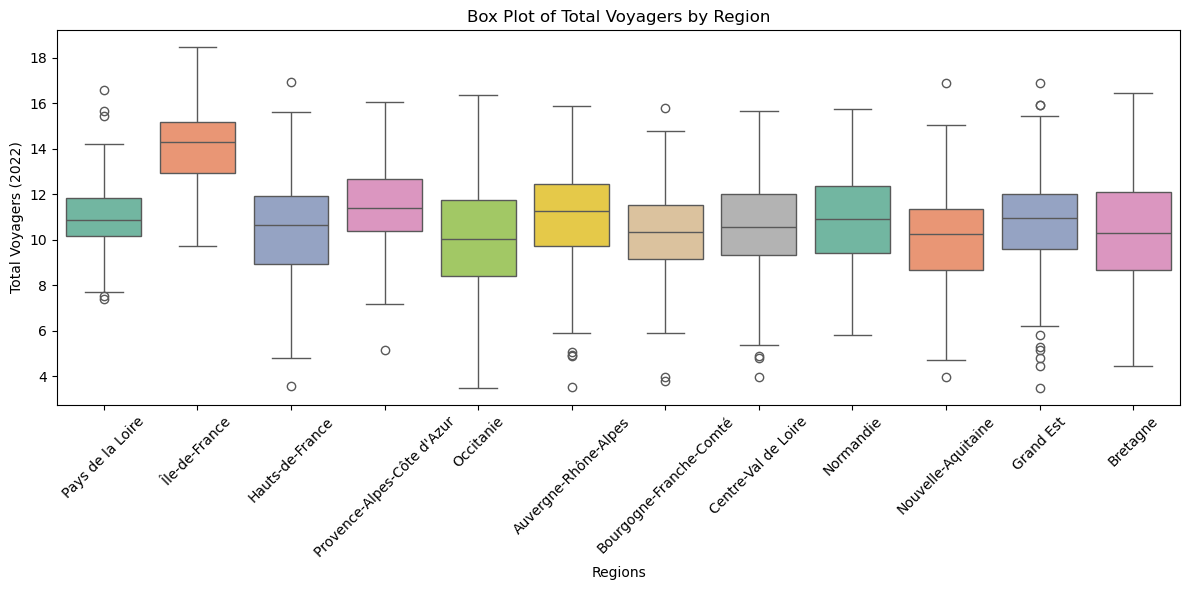

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
29  combinaisons des catégories sont significativement différentes


In [241]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='total_voyageurs_2022_log')

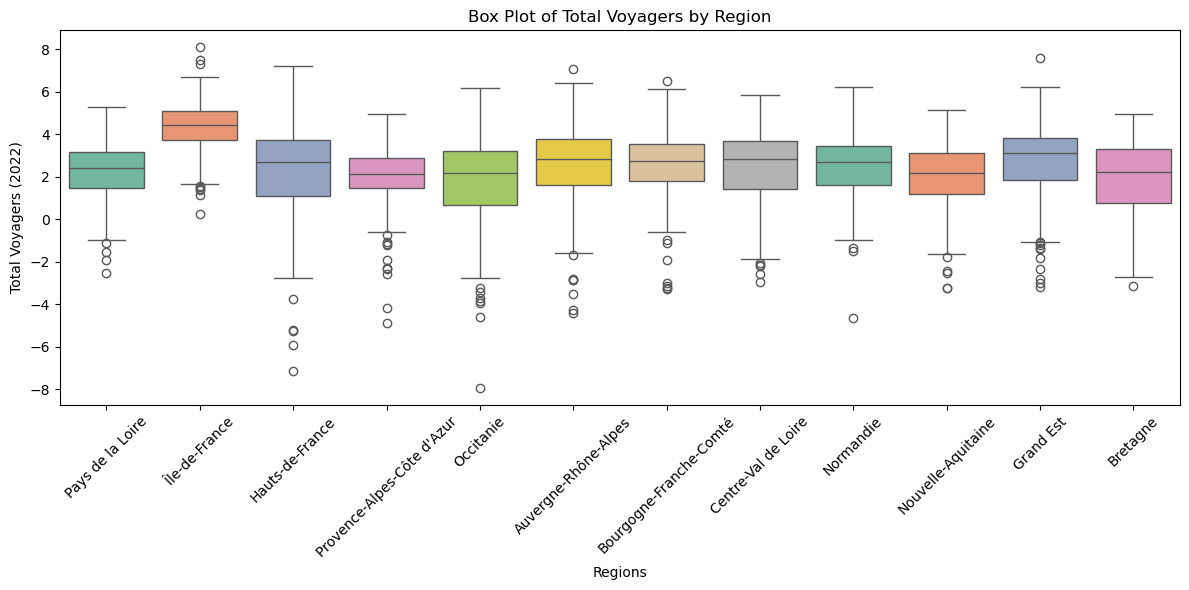

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
26  combinaisons des catégories sont significativement différentes


In [242]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='ratio_voyag_popul_log')


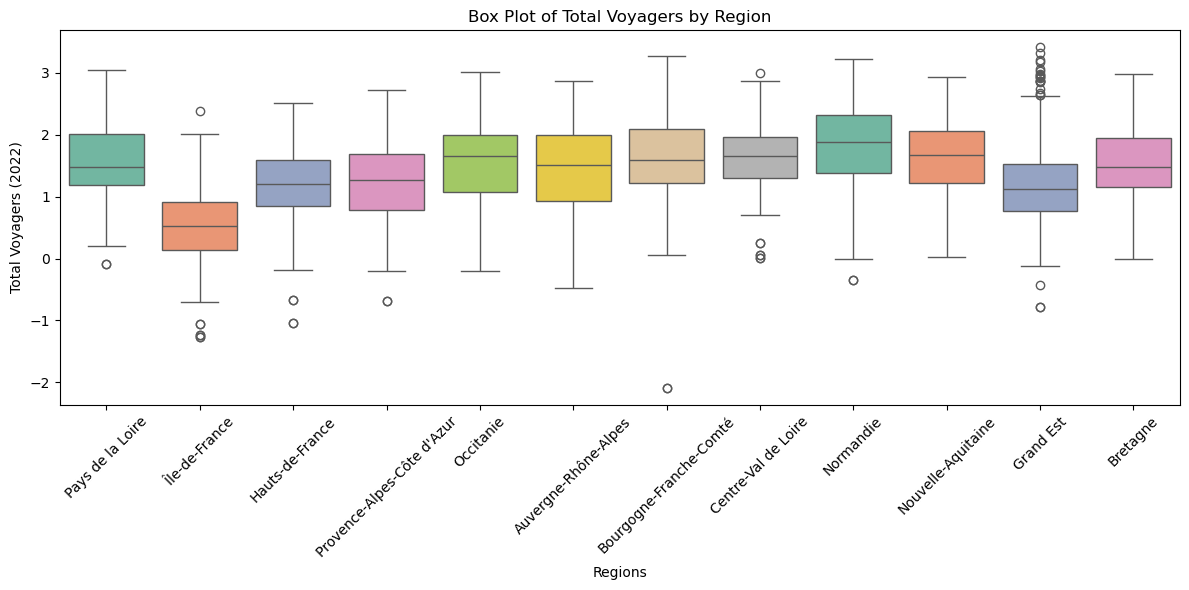

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
35  combinaisons des catégories sont significativement différentes


In [243]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='dist_closest_station_km_log')

lets classify stations!

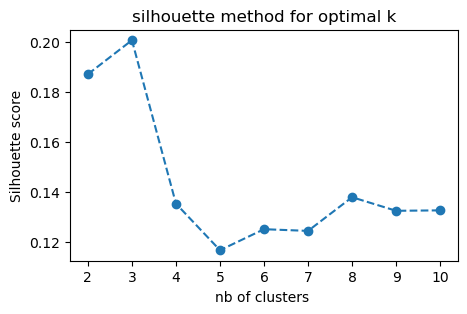

In [271]:
#avant de faire le kmeans il faut enlever els variables où il y a bcp de 0->les résultats seront très différents sinon et enlevons lat lon (pas utiles)

X = (
    df.select_dtypes(include=[np.number])
    .drop(
        ["lon_gare","lat_gare","pagri2022_log","ratio_voyag_popul_log"],
          
        axis=1,
    )
    
)
#comme kmeans c'est le calcul itératif de la distance euclidienne, il faut normaliser les variables
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

silhouette_scores = []
k_range = range(2, 11)  # essayons 11 centroides pour le KMEANS et regardons là où le silouette est max

#faisons kmeans 10 fois et gardons les scores pour les plot après
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_standardized)
    score = silhouette_score(X_standardized, cluster_labels)
    silhouette_scores.append(score)

#c'est la méthode Silhouette
plt.figure(figsize=(5, 3))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('nb of clusters ')
plt.ylabel('Silhouette score')
plt.title('silhouette method for optimal k')
plt.show()


In [274]:

print("doing kmeans with 3 centroids")
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(X_standardized)
df["cluster_labels"]=cluster_labels

doing kmeans with 3 centroids


In [276]:

df['is_idf'] = np.where(df['regions'] == 'Île-de-France', 1, 0)
#utilisons la fonction calculate pour calculer les statistiques aggrégées par cluster obtenu
#cette fonction est très utile et simple à utiliser dans chaque projet python 
clustered_results=calculate(
    df,
    group=["cluster_labels"],
    fields_stats_names=[
        ["total_voyageurs_2022", "count","nb_stations"],
        ["total_voyageurs_2022", "mean"],
        ["psup2022", "mean"],
        ["dist_closest_station_km", "mean"],
        ["pcadr2022", "mean"],
        ["pouvr2022", "mean"],
        ["is_idf", "sum","nb IDF stations"],
        ["pop2022", "mean"],
        ["pagri2022", "mean"],
        ["pchom2022", "mean"],
    ],
)
#en se basant sur les statistiques obtenues, on peut renommer les cluster en qqch de plus créatif et parlant:
cluster_names = {0: 'Quiet Farmlands', 1: 'Provincial Heartlands', 2: 'Metropolitan Areas'}
clustered_results['cluster_labels'] = clustered_results['cluster_labels'].map(cluster_names)
clustered_results


,cluster_labels,nb_stations,total_voyageurs_2022_mean,psup2022_mean,dist_closest_station_km_mean,pcadr2022_mean,pouvr2022_mean,nb IDF stations,pop2022_mean,pagri2022_mean,pchom2022_mean
0,Quiet Farmlands,92,22333.82,0.23,6.80,0.08,0.20,0,950.63,0.20,0.07
1,Provincial Heartlands,1834,200928.21,0.23,5.81,0.09,0.27,65,7182.96,0.01,0.07
2,Metropolitan Areas,864,1993878.37,0.43,2.62,0.25,0.14,310,43308.68,0.00,0.07


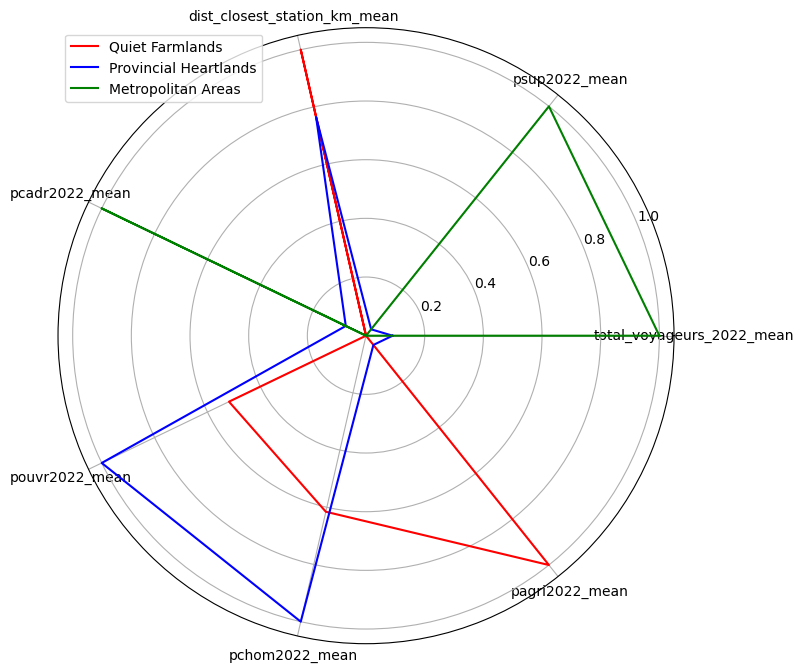

In [ ]:

columns_to_normalize = ['total_voyageurs_2022_mean', 'psup2022_mean', 
                        'dist_closest_station_km_mean', 'pcadr2022_mean', 'pouvr2022_mean', 
                        "pchom2022_mean","pagri2022_mean"]

#Normalizer avec MinMaxScaler
scaler = MinMaxScaler()
df_normalized = clustered_results.copy()  
df_normalized[columns_to_normalize] = scaler.fit_transform(clustered_results[columns_to_normalize])
#faire le radar plot
radar_data = df_normalized[["cluster_labels"] + columns_to_normalize].set_index('cluster_labels')
categories = radar_data.columns
N = len(categories)

#faire le radar plot pour chaque cluster obtenu en utilisant la formule du cercle
#je me suis inspiré des ressources https://www.pythoncharts.com/matplotlib/radar-charts/
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
colors = ['red', 'blue', 'green']

plt.figure(figsize=(8, 8))
for idx, (row, color) in enumerate(zip(radar_data.iterrows(), colors)):
    cluster_label, row_data = row  
    values = row_data.tolist()
    values =values+ values[:1] 
    plt.polar(angles, values, label=cluster_label, color=color)

plt.xticks(angles[:-1], categories)

plt.legend(loc='upper left')
plt.show()